In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Import libraries**

In [3]:
import numpy as np
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from nltk import FreqDist

from keras import regularizers
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## **Data Understanding**

In [4]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train_essays.csv")
df.head()

,id,prompt_id,text,generated
0,0059830c,0,Cars. Cars have been around since they became ...,0
1,005db917,0,Transportation is a large necessity in most co...,0
2,008f63e3,0,"""America's love affair with it's vehicles seem...",0
3,00940276,0,How often do you ride in a car? Do you drive a...,0
4,00c39458,0,Cars are a wonderful thing. They are perhaps o...,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1378 entries, 0 to 1377
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1378 non-null   object
 1   prompt_id  1378 non-null   int64 
 2   text       1378 non-null   object
 3   generated  1378 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 43.2+ KB


In [6]:
df.shape

(1378, 4)

In [7]:
df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

In [8]:
df['text'][0]

'Cars. Cars have been around since they became famous in the 1900s, when Henry Ford created and built the first ModelT. Cars have played a major role in our every day lives since then. But now, people are starting to question if limiting car usage would be a good thing. To me, limiting the use of cars might be a good thing to do.\n\nIn like matter of this, article, "In German Suburb, Life Goes On Without Cars," by Elizabeth Rosenthal states, how automobiles are the linchpin of suburbs, where middle class families from either Shanghai or Chicago tend to make their homes. Experts say how this is a huge impediment to current efforts to reduce greenhouse gas emissions from tailpipe. Passenger cars are responsible for 12 percent of greenhouse gas emissions in Europe...and up to 50 percent in some carintensive areas in the United States. Cars are the main reason for the greenhouse gas emissions because of a lot of people driving them around all the time getting where they need to go. Article

**Checking null values in columns**

In [9]:
df.isnull().sum()

id           0
prompt_id    0
text         0
generated    0
dtype: int64

In [10]:
# checking column type
print(type(df["text"]))
print(type(df["generated"]))

<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


In [11]:
df['generated'].value_counts()

generated
0    1375
1       3
Name: count, dtype: int64

#### Since the original dataset is containing 1378 samples which are not enough for expected model performamce. Model is overfittig upon this dataset. So now Data Augmentation is required. The following dataset is the extended dataset which is going to be augmented to the original dataset.

In [12]:
synthetic_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/synthetic_data.csv")

In [13]:
synthetic_df.head()

,id,prompt_id,text,generated
0,513c576d,1,Many people question why we use the Electoral ...,0
1,6ce5f8fb,0,"Dear Senator Nelson, In recent years, many peo...",0
2,9f45f83a,1,"Dear Mr. Senator, I believe that the way our e...",0
3,71168011,0,How could we get the reduction of Greenhouse G...,0
4,2f216503,0,There has beeon a major awareoness of the effe...,0


In [14]:
synthetic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         50000 non-null  object
 1   prompt_id  50000 non-null  int64 
 2   text       50000 non-null  object
 3   generated  50000 non-null  int64 
dtypes: int64(2), object(2)
memory usage: 1.5+ MB


In [15]:
synthetic_df.shape

(50000, 4)

In [16]:
synthetic_df['text'][1]

'Dear Senator Nelson, In recent years, many people have called for the change of the presidential election process. Specifically, the Electoral College. Many consider it a pointless, unfair, and archaic system that denies the people the liberty of choosing their president. However, I believe the Electoral College is a necessity in modern America. Although it is as old as the country itself, it is still relevant and useful today.\n\nThe Electoral College ensures the outcome of an election. Without the Electoral College, the election may possibly need multiple reruns as a result of a tie in the popular vote. According to "Does the Electoral College work?" by the Office of the Federal Register, "The Electoral College consists of 538 electors. A majority of 270 electoral votes is required to elect the president". With that few of electors, it reduces the chances of a tie occurring. Although it can happen however, it\'s not probable. For example, if two candidates ever had a tie among the p

In [17]:
synthetic_df.isnull().sum()

id           0
prompt_id    0
text         0
generated    0
dtype: int64

In [18]:
u = synthetic_df['generated'].value_counts() #count() #nunique()
u

generated
0    49501
1      499
Name: count, dtype: int64

# **Data Preprocessing**

**Dropping columns which we do not need in both original and synthetic datasets for training**

In [19]:
df           = df.drop(columns = ['id', 'prompt_id'], axis=1)
synthetic_df = synthetic_df.drop(columns = ['id', 'prompt_id'], axis= 1)

In [20]:
print("columns of original dataset: ", df.columns)
print("columns of synthetic dataset: ", synthetic_df.columns)

columns of original dataset:  Index(['text', 'generated'], dtype='object')
columns of synthetic dataset:  Index(['text', 'generated'], dtype='object')


**Let's merge the generated (sysnthetic dataset) with the original dataset horizontally.**

In [21]:
merged_datasets = [df, synthetic_df]
new_df = pd.concat(merged_datasets, ignore_index=True)
new_df.shape

(51378, 2)

In [22]:
new_df.columns

Index(['text', 'generated'], dtype='object')

# **Plotting the distribution of input sequences**

In [23]:
sequence_lengths = [len(sequence.split()) for sequence in new_df['text']]

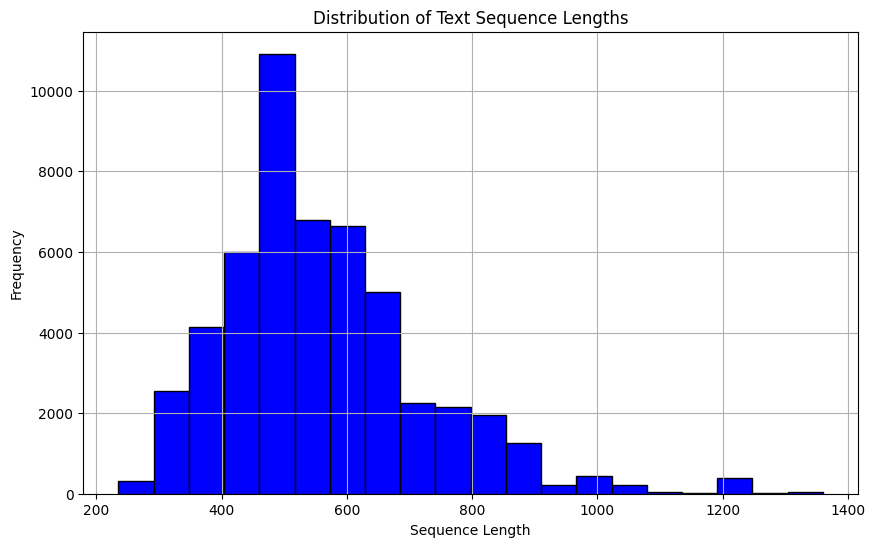

In [24]:
# Plot the distribution of sequence lengths
plt.figure(figsize=(10, 6))
plt.hist(sequence_lengths, bins=20, color='blue', edgecolor='black')
plt.title('Distribution of Text Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [25]:
# Calculate the 95th percentile length
max_length = int(np.percentile(sequence_lengths, 95))
print(f"95th percentile length: {max_length}")

95th percentile length: 858


In [26]:
# Calculate the maximum length
max_length_max = max(sequence_lengths)
print(f"Maximum length: {max_length_max}")

Maximum length: 1360


In [27]:
def count_words(doc):
    split_words = doc.split()
    num_of_words = len(split_words)

    return num_of_words

#Apply the function the 'text' column of a dataset
total_words = new_df['text'].apply(count_words).sum()

# print the sum of the word count
print("Total number of words in a dataset is:", total_words)



Total number of words in a dataset is: 28877620


### **Maximum length of text document**

In [28]:
def max_text(text_column):

    text_length_list = []
    for document in text_column:
        words = document.split()
        text_length_list.append(len(words))

    max_length = max(text_length_list)

    return max_length
print(f"The maximum length of text is: {max_text(new_df['text'])}")

The maximum length of text is: 1360


### Average length of text column

#### Choosing the mean length of the documents as the value for the parameter "output_sequence_length"

In [29]:
def calculate_mean(text):
    text_list = []
    for doc in text:
        words = doc.split()
        text_list.append(len(words))

    sum_of_lengths = sum(text_list)
    average = sum_of_lengths/len(new_df)

    return average
print(f"The average length of the col text is: {calculate_mean(new_df['text'])}")

The average length of the col text is: 562.0619720502939


### **Vacabulary size**

In [30]:
def collect_unique_words(doc):
    split_words = word_tokenize(doc)                  # spliting words into tokens/words
    unique_words = set(split_words)                   # collecting unique words.Create a set to remove duplicates automatically

    return unique_words

unique_words_per_doc = new_df['text'].apply(collect_unique_words)
print(unique_words_per_doc)

0        {'s, limit, greenhouse, motorist, sidewalks, a...
1        {'s, greenhouse, sidewalks, health, at, gases,...
2        {stem, behind, if, fact, effcts, users, colomb...
3        {skating, each, improved, if, ignition, taking...
4        {if, Your, stuck, over, plates, can, off, plac...
                               ...                        
51373    {mayor, easy, if, appealing, paths, Doug, Like...
51374    {'s, focusing, votes, different, at, each, can...
51375    {damage, limit, pollutants, tell, study, Cars,...
51376    {behind, each, if, president, last, faced, rel...
51377    {different, 's, votes, founding, two, if, Coll...
Name: text, Length: 51378, dtype: object


In [31]:
# collecting all unique words
# Flatten the list of sets whcih composed of unique words-collected from the dataset above
all_unique_words = set().union(*unique_words_per_doc)

vocabulary_size = len(all_unique_words)
print("The total number of vocabulary in dataset is: ", vocabulary_size)

The total number of vocabulary in dataset is:  18712


In [32]:
# Calculate frequency distribution
freq_dist = FreqDist(all_unique_words)

# Find the most common words
most_common_words = freq_dist.most_common()

print(f"The most common words are: {len(most_common_words)}")

The most common words are: 18712


## Train_Test Split

In [33]:
shuffled_df = new_df.sample(frac=1, random_state=42)  # Shuffle with random seed for reproducibility

# Separate features (X) and labels (y)
X = new_df["text"]            #df.drop(columns=['label_column'])
y = new_df["generated"]       #df['label_column']

# First split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Then split the train set further into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

# Print the sizes of the subsets
print("Train set size:", len(X_train))
print("Validation set size:", len(X_val))
print("Test set size:", len(X_test))

Train set size: 34936
Validation set size: 6166
Test set size: 10276


In [34]:
train_data = pd.DataFrame({"text": X_train, 'label': y_train})
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'], train_data['label']))

#val_data = pd.DataFrame({"text": X_val, 'label': y_val})
#validation_dataset = tf.data.Dataset.from_tensor_slices((val_data['text'], val_data['label']))

In [35]:
texts = new_df['text'].values
labels = new_df['generated'].values

# Inspect class distribution
class_counts = np.bincount(labels)
print(f'Class distribution: {class_counts}')

Class distribution: [50876   502]


In [36]:
from sklearn.utils.class_weight import compute_class_weight

In [37]:
# Debug: Check the classes and their counts
train_class_counts = np.bincount(y_train)
val_class_counts = np.bincount(y_val)
print(f'Training class counts: {train_class_counts}')
print(f'Validation class counts: {val_class_counts}')

Training class counts: [34598   338]
Validation class counts: [6099   67]


In [38]:
# Compute class weights
unique_classes = np.unique(y_train)  # Get unique classes from y_train
class_weights = compute_class_weight(class_weight='balanced', classes=unique_classes, y=y_train)
class_weights = {cls: weight for cls, weight in zip(unique_classes, class_weights)}
print(f'Class weights: {class_weights}')

Class weights: {0: 0.5048846754147639, 1: 51.680473372781066}


In [39]:
print(f'Keys in class weights dictionary: {class_weights.keys()}')


Keys in class weights dictionary: dict_keys([0, 1])


## **Text Vectorization**

In [40]:
# max_len
VOCAB_SIZE = vocabulary_size
encoder = tf.keras.layers.TextVectorization(
          max_tokens=VOCAB_SIZE,                     # Vocabulary size
          output_mode = 'int',
          standardize='lower_and_strip_punctuation',
          #split = 'whitespace'
          output_sequence_length = max_length )
#encoder.adapt(train_dataset.map(lambda text, label: text))

In [41]:
# Adapt the encoder on the training texts
#train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = tf.data.Dataset.from_tensor_slices((train_data['text'], train_data['label']))
encoder.adapt(train_dataset.map(lambda text, label: text))

# Vectorize the training and validation texts using the adapted encoder
X_train_vect = encoder(X_train)
X_val_vect = encoder(X_val)
X_test_vect = encoder(X_test)

## **Resampling for Balancing the Imbalance of Classes**
Since the dataset is containing high class imbalances, therefore a techiniqe **Random Over Sampling Technique**: is a resampling technique by applying a "Random Over Sampler" to increase the number of instaces in the minority class by duplicating them

In [42]:
# Apply RandomOverSampler to the training data
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vect.numpy(), y_train)

# Verify the new class distribution
unique_train_resampled_classes, counts_train_resampled = np.unique(y_train_resampled, return_counts=True)
print(f'Class distribution after resampling: {dict(zip(unique_train_resampled_classes, counts_train_resampled))}')

Class distribution after resampling: {0: 34598, 1: 34598}


# **Creating model**

In [43]:
# Define the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(max_length,)),  # Add input layer with the shape of the vectorized input
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=64, return_sequences=True)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

### **Compile the model**

In [44]:
#model.compile(loss='binary_crossentropy', optimizer=Adam(learning rate = 0.001), metrics=['accuracy'])
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=['accuracy'])

### **Train the model**

In [45]:
history  = model.fit(X_train_resampled, y_train_resampled, epochs=5, batch_size=32, validation_data=(X_val_vect, y_val))

Epoch 1/5
2163/2163 [==============================] - 348s 151ms/step - loss: 0.3357 - accuracy: 0.8458 - val_loss: 0.3378 - val_accuracy: 0.8437
Epoch 2/5
2163/2163 [==============================] - 250s 115ms/step - loss: 0.3016 - accuracy: 0.8601 - val_loss: 0.3352 - val_accuracy: 0.8527
Epoch 3/5
2163/2163 [==============================] - 241s 111ms/step - loss: 0.2994 - accuracy: 0.8608 - val_loss: 0.3825 - val_accuracy: 0.7974
Epoch 4/5
2163/2163 [==============================] - 234s 108ms/step - loss: 0.2979 - accuracy: 0.8618 - val_loss: 0.3632 - val_accuracy: 0.7963
Epoch 5/5
2163/2163 [==============================] - 233s 108ms/step - loss: 0.2970 - accuracy: 0.8627 - val_loss: 0.3793 - val_accuracy: 0.8102


### **Evaluation**

In [46]:
test_loss, test_accuracy = model.evaluate(X_test_vect, y_test)
print("Test_loss: ", test_loss)
print("Test_accuracy: ", test_accuracy)

322/322 [==============================] - 14s 44ms/step - loss: 0.3761 - accuracy: 0.8079
Test_loss:  0.3760998845100403
Test_accuracy:  0.807901918888092


### **Prediction**

In [47]:
y_pred = model.predict(X_test_vect)#.ravel()    # Ensuring 1-A array of predicted probabilities
print(y_pred)

322/322 [==============================] - 18s 43ms/step
[[3.0745810e-01]
 [1.6731929e-04]
 [2.9544529e-01]
 ...
 [2.5265361e-04]
 [1.1470924e-04]
 [1.7857208e-04]]


In [48]:
y_pred.shape

(10276, 1)

In [49]:
y_pred_ravel = model.predict(X_test_vect).ravel()    # Ensuring 1-A array of predicted probabilities
print(y_pred_ravel)

322/322 [==============================] - 14s 43ms/step
[3.0745810e-01 1.6731929e-04 2.9544529e-01 ... 2.5265361e-04 1.1470924e-04
 1.7857208e-04]


In [50]:
print(f"Range of predicted probabilities: {y_pred_ravel.min()} to {y_pred_ravel.max()}")

Range of predicted probabilities: 5.825953485327773e-05 to 0.9698007702827454


### **Calculation of Classification Report**

In [51]:
# converting predicted probabilities to binary labels
y_pred_binary = (y_pred_ravel > 0.5).astype(int)
y_test_binary = y_test.astype(int)

In [52]:
report = classification_report(y_test_binary, y_pred_binary)
accuracy= accuracy_score(y_test_binary, y_pred_binary)


print(report)
print("\n*********************************")
print(f"Accuracy score: {accuracy}")

              precision    recall  f1-score   support

           0       1.00      0.81      0.89     10179
           1       0.03      0.66      0.06        97

    accuracy                           0.81     10276
   macro avg       0.51      0.73      0.48     10276
weighted avg       0.99      0.81      0.89     10276


*********************************
Accuracy score: 0.8079019073569482


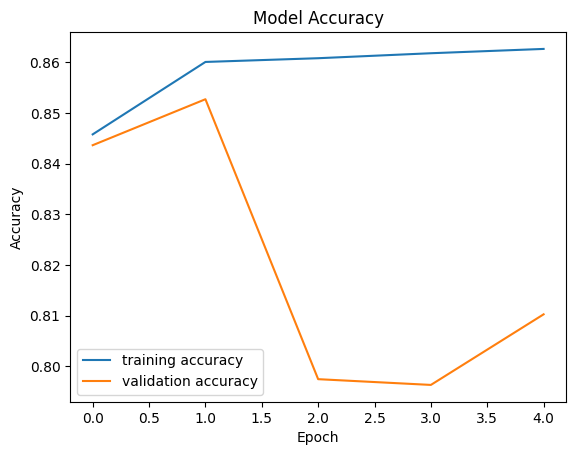

In [53]:
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

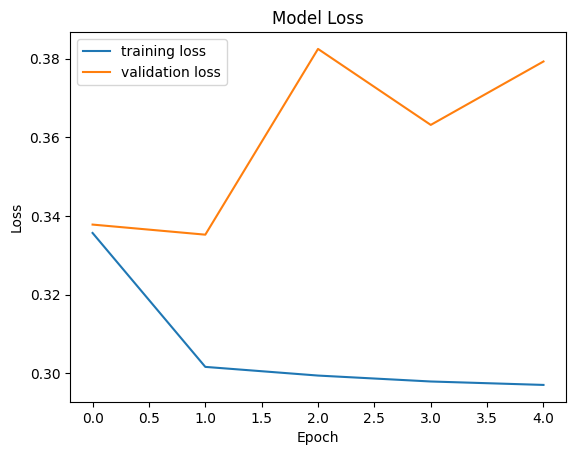

In [54]:
# Plot training loss
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### **Display of Confusion Matrix**

In [55]:
conf_matrix = confusion_matrix(y_test_binary, y_pred_binary)
print(conf_matrix)

[[8238 1941]
 [  33   64]]


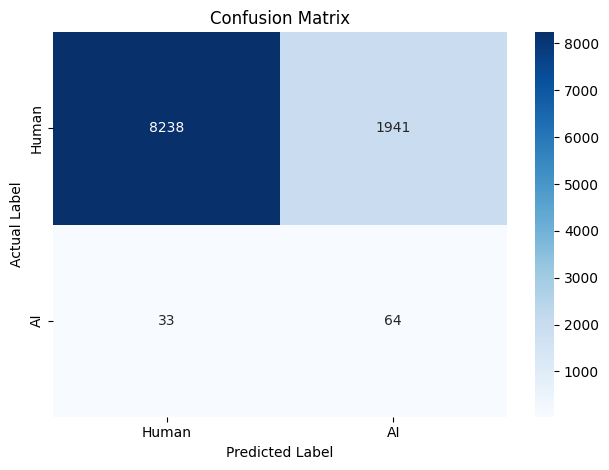

In [56]:
import seaborn as sns

sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])  # Format as integers
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

### **Calculate and Display of ROC Curve**

In [57]:
fpr , tpr, thresholds = roc_curve(y_test_binary,y_pred_binary)
roc_auc = auc(fpr, tpr)
roc_auc

0.7345535532524512

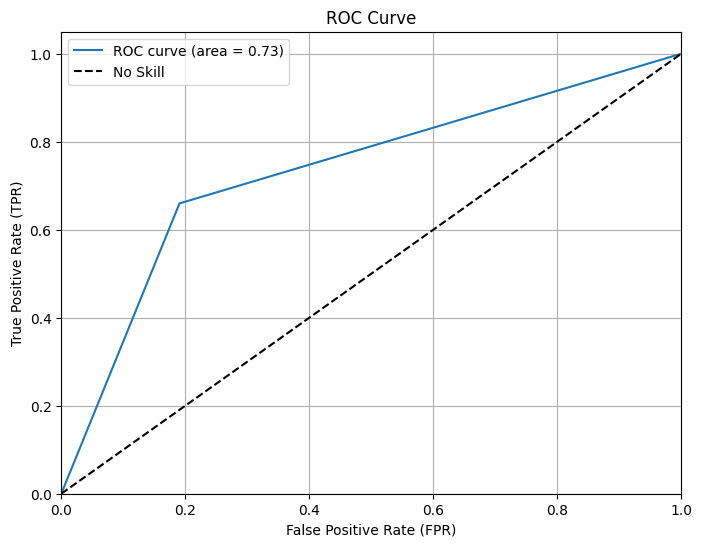

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')  # Reference line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend()
plt.grid(True)
plt.show()


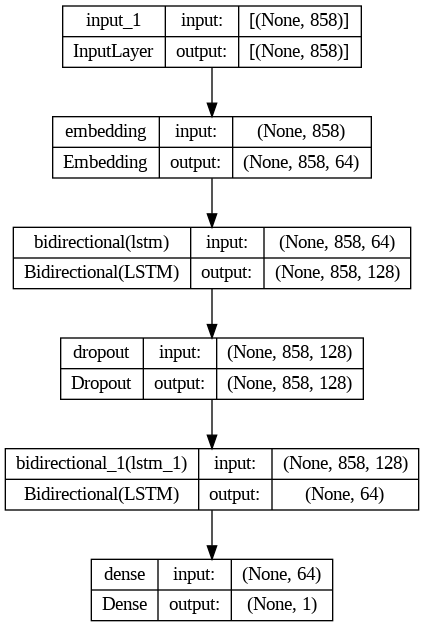

In [59]:
# prompt: How can i plot the model with tensorflow?

# Visualize the model
tf.keras.utils.plot_model(model, show_shapes=True)
